## Notebook for Ishikawa-2022 QC, clustering and finding stem cells 
### Developed by: Anna Maguza

### Institute of Computational Biology - Computational Health Centre - Hemlholtz Munich

### 23 January 2023

#### Load packages

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import scvi
import anndata as ad
import seaborn as sns
import numpy as np
from scvi.model.utils import mde
import pymde

Global seed set to 0
/home/icb/anna.maguza/miniconda3/envs/scvi_env/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/icb/anna.maguza/miniconda3/envs/scvi_env/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


#### Setup Cells

In [2]:
%matplotlib inline

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.9.3 pandas==1.5.1 scikit-learn==1.1.3 statsmodels==0.13.5 pynndescent==0.5.8


#### Data Upload

In [4]:
input_file = '/lustre/groups/talaveralopez/datasets/Colorectal_cancer/Mice_intestine/Ishikawa-2022-mice/GSM6381794_anndata_raw-2.h5ad'  # the file that will store the analysis results
output_file = '/lustre/groups/talaveralopez/datasets/Colorectal_cancer/Mice_intestine/Ishikawa-2022-mice/GSM6381794_anndata_output-2.h5ad'  # the file that will store the analysis results

In [5]:
#Anndata upload
Ishikawa_anndata = sc.read_h5ad(input_file)
Ishikawa_anndata.X

/home/icb/anna.maguza/miniconda3/envs/scvi_env/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


<3638x31053 sparse matrix of type '<class 'numpy.float32'>'
	with 8586005 stored elements in Compressed Sparse Column format>

#### Quality Check

In [6]:
Ishikawa_anndata.var.index = Ishikawa_anndata.var['gene_name']

normalizing counts per cell
    finished (0:00:00)


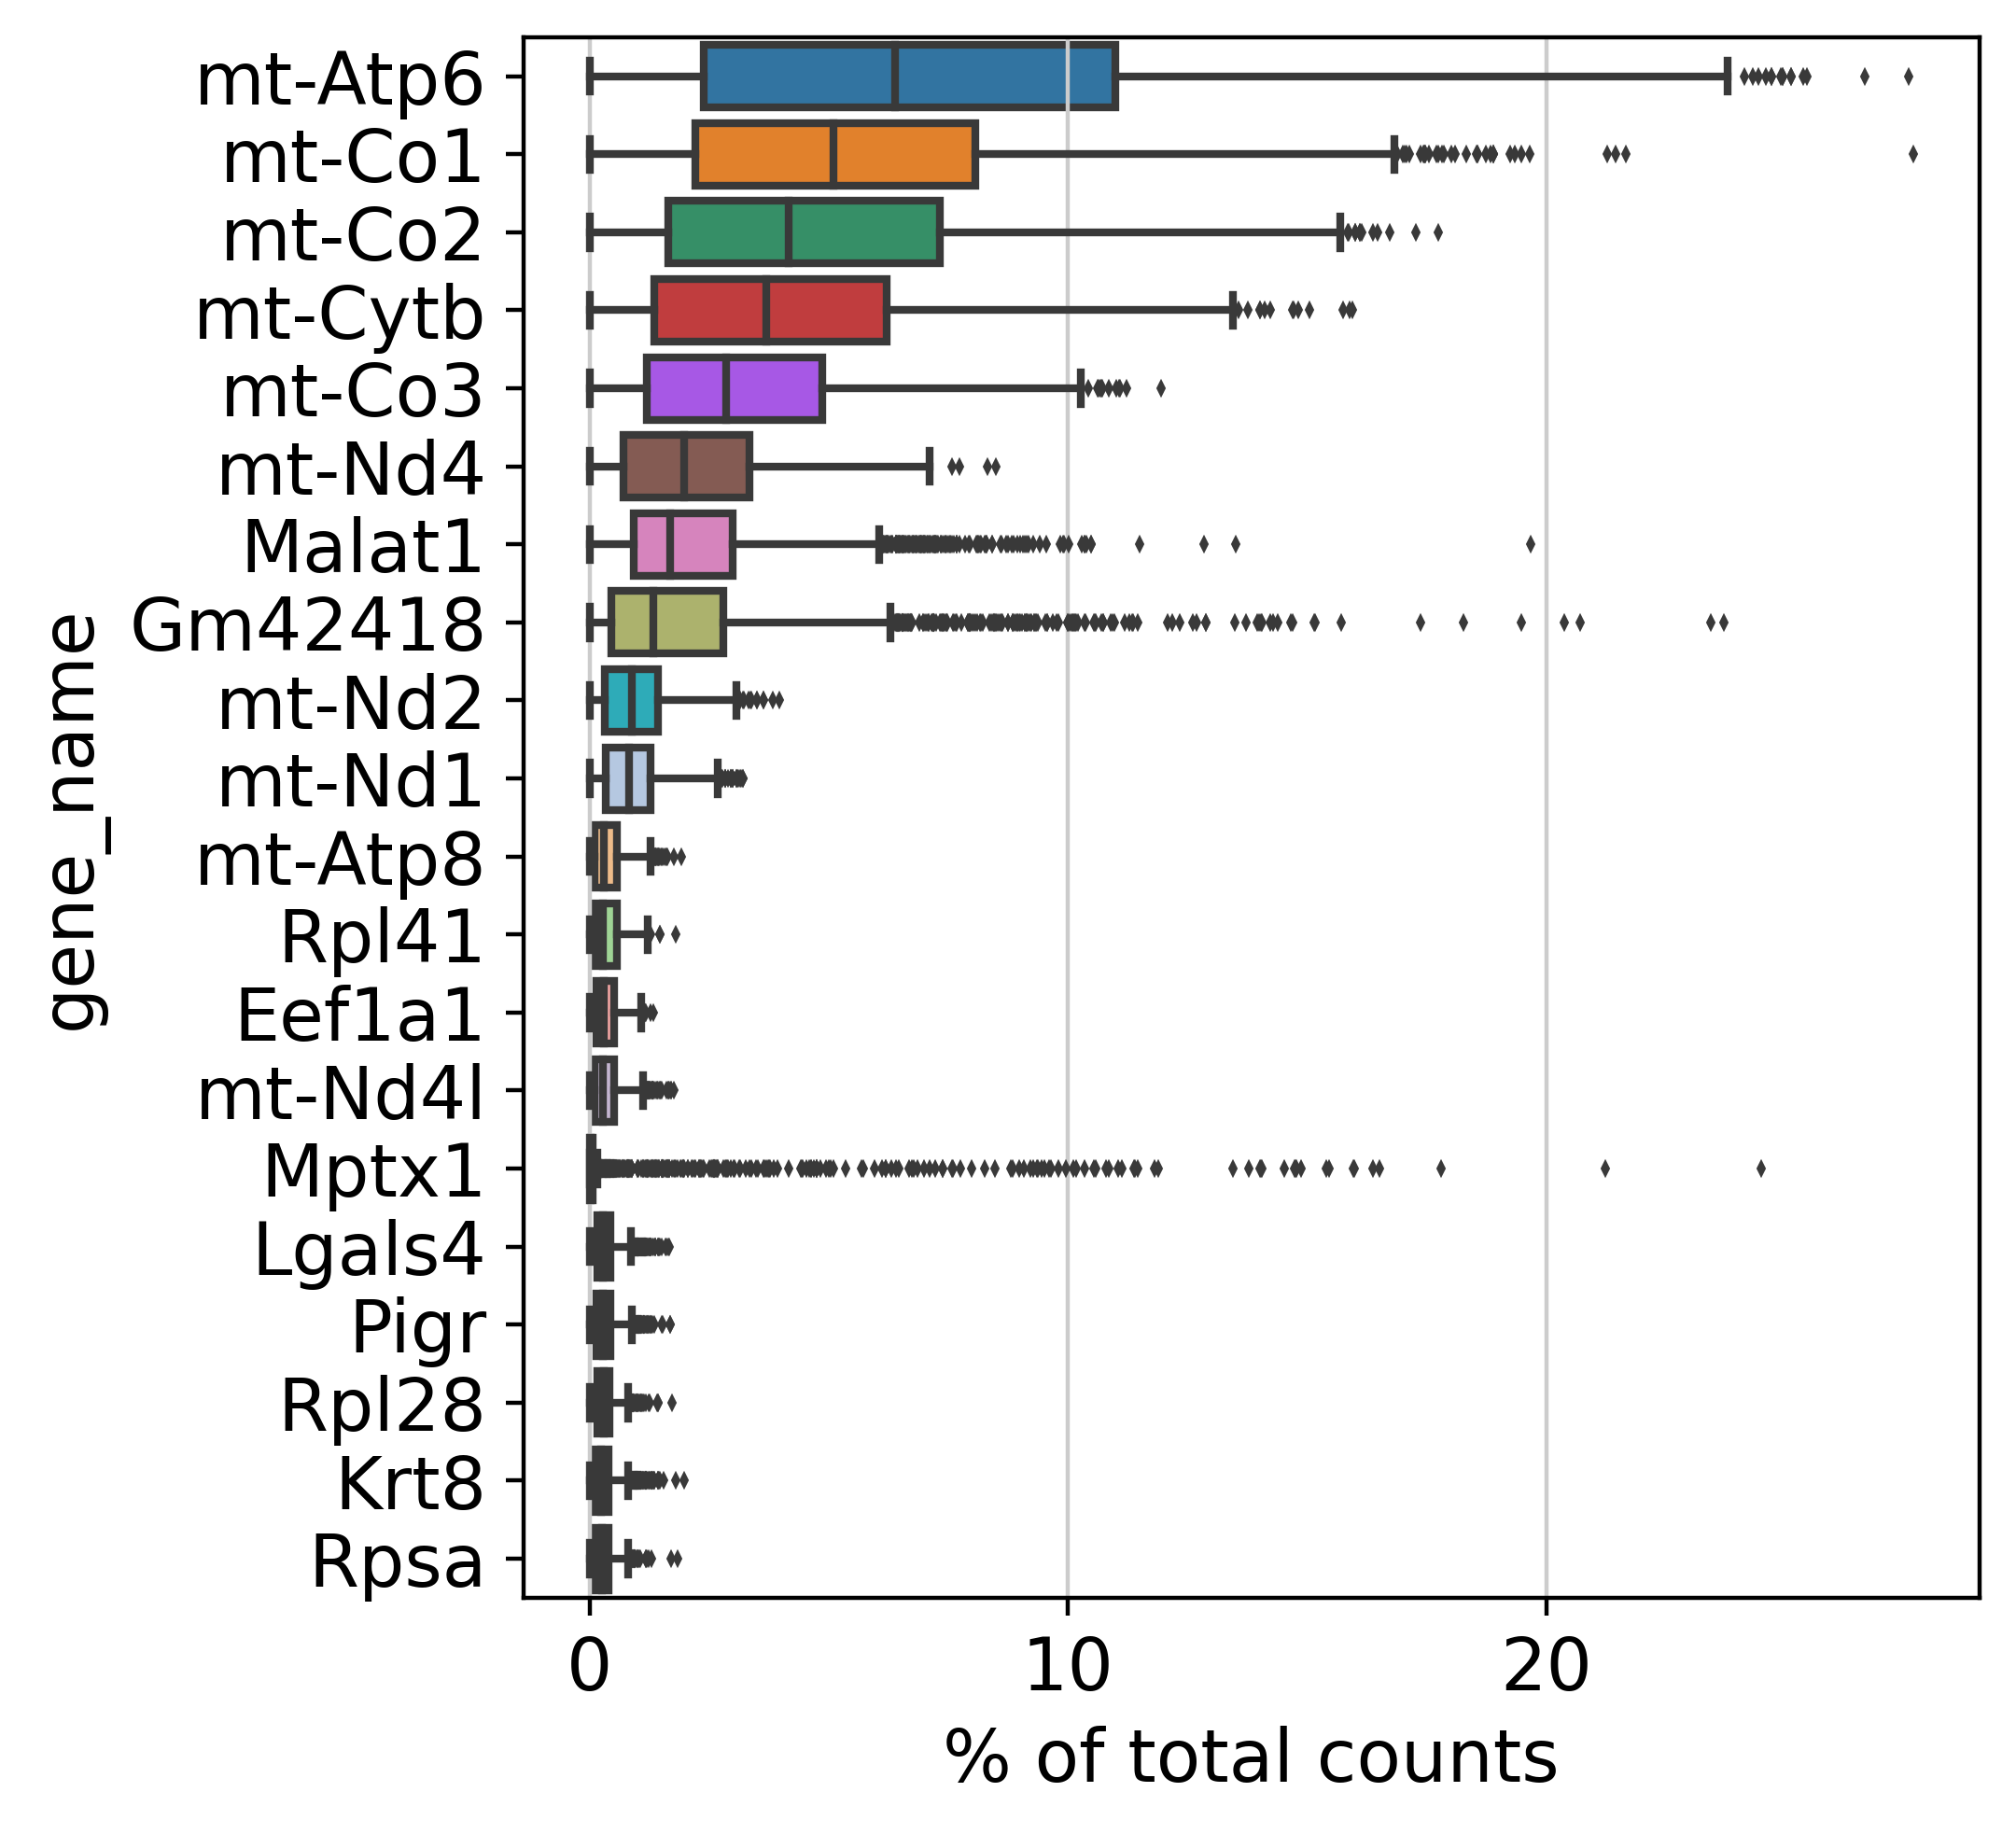

In [128]:
sc.set_figure_params(figsize=(5, 5),dpi=200)
#Show those genes that yield the highest fraction of counts in each single cell, across all cells
sc.pl.highest_expr_genes(Ishikawa_anndata, n_top=20, )

In [129]:
#Calculate quality control metrics
sc.pp.calculate_qc_metrics(Ishikawa_anndata, expr_type = 'counts', var_type='genes', percent_top = None, inplace=True)

In [130]:
#Adding percentage of mitochondrial genes
Ishikawa_anndata.var['mt'] = Ishikawa_anndata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(Ishikawa_anndata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [131]:
#Adding percentage of ribosomial genes
Ishikawa_anndata.var['ribo'] = Ishikawa_anndata.var_names.str.startswith(("Rps","Rpl"))  # annotate the group of ribosomal genes as 'ribo'
sc.pp.calculate_qc_metrics(Ishikawa_anndata, qc_vars=['ribo'], percent_top=None, log1p=False, inplace=True)

In [132]:
Ishikawa_anndata.obs

,cell_index,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
0,AAACCCAAGAGGATGA-1,557,6.324359,880.0,6.781058,28.0,3.181818,223.0,25.340908
1,AAACCCAGTAGGTTTC-1,1822,7.508239,5161.0,8.549079,1376.0,26.661501,724.0,14.028289
2,AAACCCATCGCGCCAA-1,3724,8.222822,14883.0,9.608042,2193.0,14.734933,2177.0,14.627427
3,AAACGAAAGACGGTCA-1,501,6.218600,785.0,6.666957,38.0,4.840765,189.0,24.076433
4,AAACGAAAGGCTCTAT-1,4251,8.355145,19183.0,9.861832,445.0,2.319762,5478.0,28.556534
...,...,...,...,...,...,...,...,...,...
3633,TTTGTTGCAAGTCCCG-1,2242,7.715570,7176.0,8.878636,2334.0,32.525082,609.0,8.486622
3634,TTTGTTGCATGAGATA-1,1005,6.913737,2048.0,7.625107,689.0,33.642578,132.0,6.445312
3635,TTTGTTGGTCAGTCGC-1,414,6.028279,586.0,6.375025,58.0,9.897612,115.0,19.624573
3636,TTTGTTGTCGAGGCAA-1,1618,7.389564,3461.0,8.149602,902.0,26.061832,207.0,5.980930


In [133]:
Ishikawa_anndata.var.index = Ishikawa_anndata.var['gene_id']

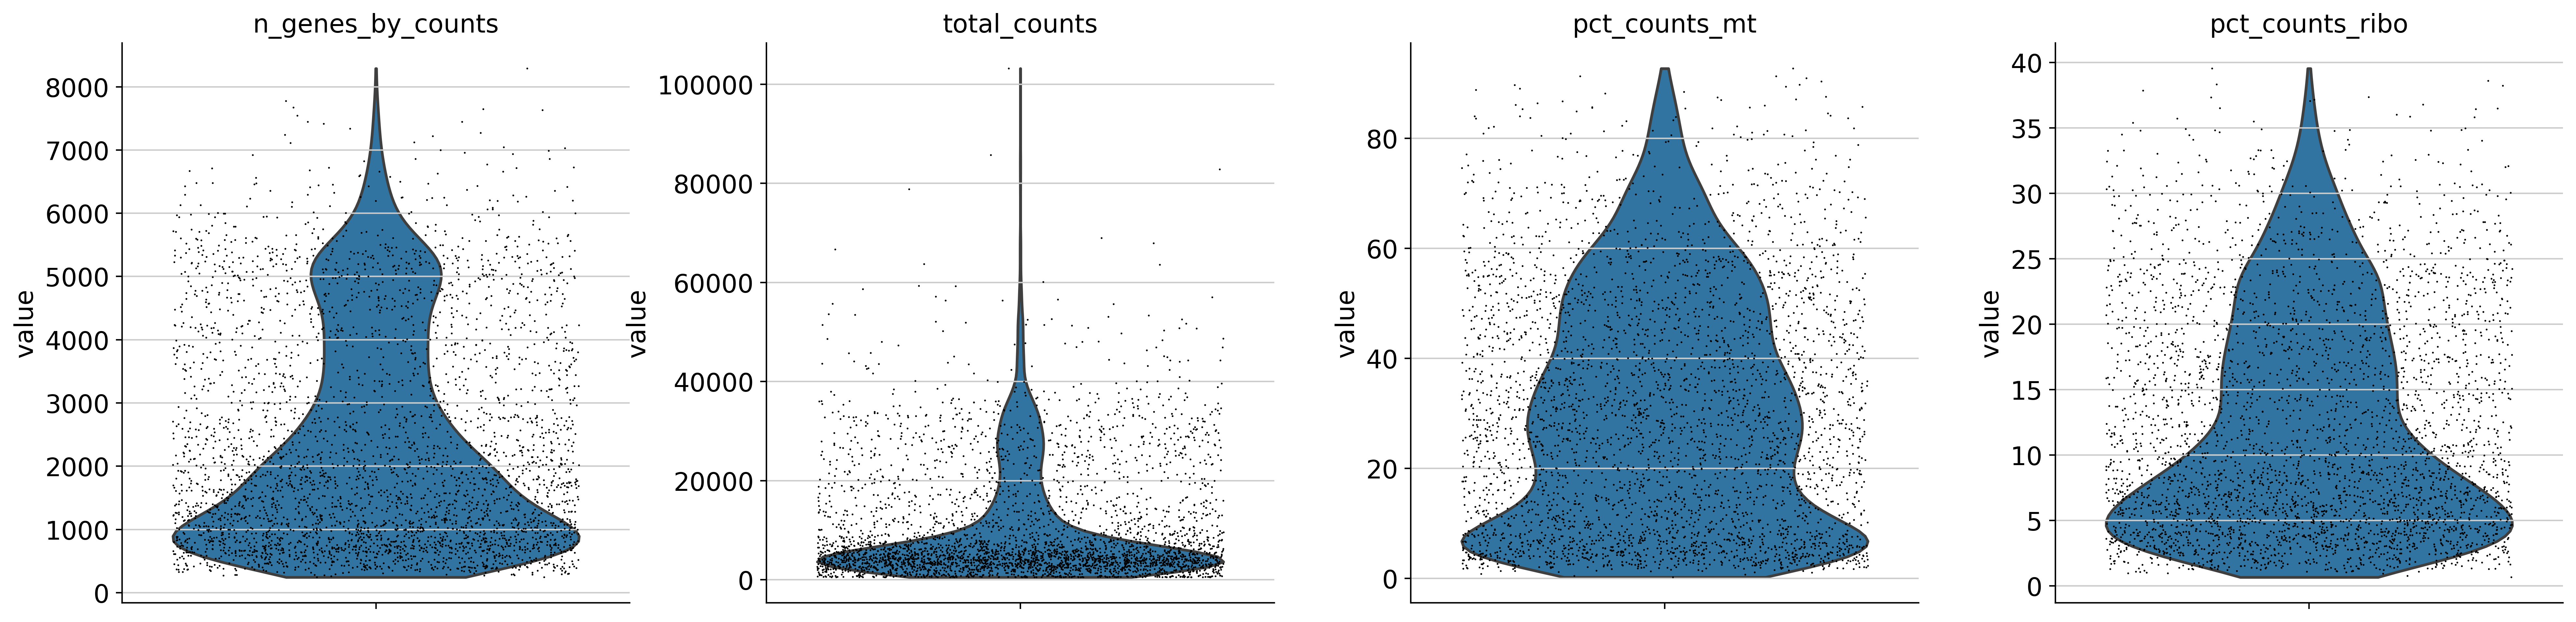

In [134]:
#A violin plot of some of the computed quality measures:
    # the number of genes expressed in the count matrix
    #the total counts per cell
    #the percentage of counts in mitochondrial genes
    #the percentage of counts in ribosomial genes
sc.pl.violin(Ishikawa_anndata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'],
             jitter=0.4, multi_panel=True)

In [135]:
#Filtering by genes
Ishikawa_anndata = Ishikawa_anndata[Ishikawa_anndata.obs.n_genes_by_counts < 5000, :]
Ishikawa_anndata = Ishikawa_anndata[Ishikawa_anndata.obs.n_genes_by_counts > 50, :]
#Filtering by counts
Ishikawa_anndata = Ishikawa_anndata[Ishikawa_anndata.obs.total_counts < 50000, :]

In [136]:
#Finding the highly variable genes (the span=1 is added because I faced an error "ValueError: b'There are other near singularities as well. 0.090619\n'")
sc.pp.highly_variable_genes(
    Ishikawa_anndata,
    flavor="seurat_v3",
    n_top_genes=7000,
    subset=True
)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


/home/icb/anna.maguza/miniconda3/envs/scvi_env/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [137]:
#Register the AnnData object with the correct key to identify the sample and the layer key with the count data.
scvi.model.SCVI.setup_anndata(Ishikawa_anndata, batch_key=None)

/home/icb/anna.maguza/miniconda3/envs/scvi_env/lib/python3.9/site-packages/scvi/data/_utils.py:114: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  warnings.warn(


In [138]:
# Correction with SCVI 3 layers and negative binomial gene likelihood
vae_3layers_nb = scvi.model.SCVI(Ishikawa_anndata, n_layers=3, n_latent=50, gene_likelihood="nb")

In [139]:
#train scVI
vae_3layers_nb.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██| 400/400 [06:33<00:00,  1.02it/s, loss=2.23e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██| 400/400 [06:33<00:00,  1.02it/s, loss=2.23e+03, v_num=1]


In [140]:
#evaluate the latent representation of each cell in the dataset and add it to the AnnData object
Ishikawa_anndata.obsm["X_scVI"] = vae_3layers_nb.get_latent_representation()

In [141]:
#cluster the dataset and visualize it the scVI latent space
sc.pp.neighbors(Ishikawa_anndata, use_rep="X_scVI")
sc.tl.umap(Ishikawa_anndata, min_dist = 0.3, spread = 3)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:19)


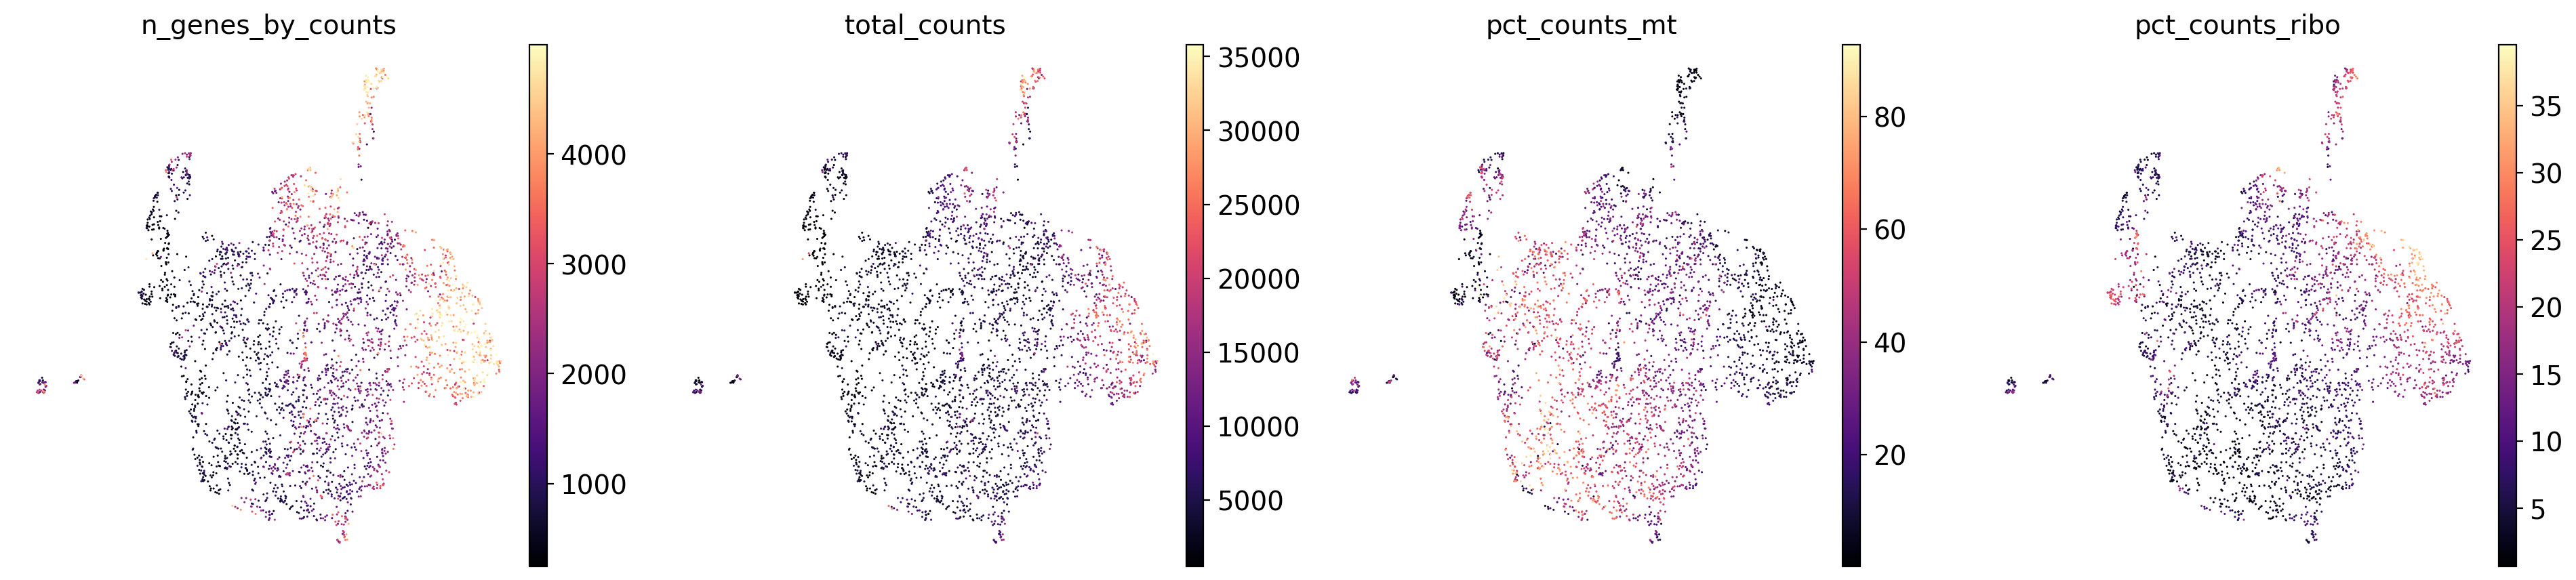

In [142]:
sc.set_figure_params(figsize=(5, 5),dpi=100)
sc.pl.umap(Ishikawa_anndata, color= ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], color_map = "magma", size = 5, frameon = False)

### Save object

In [143]:
adata_export = ad.AnnData(X = Ishikawa_anndata.X, obs = Ishikawa_anndata.obs, var = Ishikawa_anndata.var, uns = Ishikawa_anndata.uns, obsm = Ishikawa_anndata.obsm, obsp = Ishikawa_anndata.obsp)
adata_export

AnnData object with n_obs × n_vars = 3218 × 7000
    obs: 'cell_index', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels'
    var: 'gene_name', 'type', 'gene_id', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'ribo', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'distances', 'connectivities'

In [144]:
adata_export.write('/lustre/groups/talaveralopez/datasets/Colorectal_cancer/Mice_intestine/Ishikawa-2022-mice/GSM6381794_anndata_post_SCVI_nb_3layers.h5ad')

In [7]:
input_file = '/lustre/groups/talaveralopez/datasets/Colorectal_cancer/Mice_intestine/Ishikawa-2022-mice/GSM6381794_anndata_post_SCVI_nb_3layers.h5ad'  # the file that will store the analysis results
output_file = '/lustre/groups/talaveralopez/datasets/Colorectal_cancer/Mice_intestine/Ishikawa-2022-mice/GSM6381794_anndata_post_SCVI_nb_3layers_anndata_output-2.h5ad'  # the file that will store the analysis results

In [8]:
#Anndata upload
Ishikawa_anndata = sc.read_h5ad(input_file)
Ishikawa_anndata.X

<3218x7000 sparse matrix of type '<class 'numpy.float32'>'
	with 2720578 stored elements in Compressed Sparse Column format>

### Gene scores

In [9]:
Stem_cells_markers = ['ENSMUSG00000020140', 'ENSMUSG00000009248', 'ENSMUSG00000023886', 'ENSMUSG00000072235', 'ENSMUSG00000039405', 'ENSMUSG00000000142']

In [10]:
Ishikawa_anndata.var.index = Ishikawa_anndata.var['gene_id']

In [11]:
Ishikawa_anndata.var

,gene_name,type,gene_id,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,mt,ribo,highly_variable,highly_variable_rank,means,variances,variances_norm
gene_id,,,,,,,,,,,,,,,,
ENSMUSG00000025902,Sox17,Gene Expression,ENSMUSG00000025902,1,0.000550,0.000550,99.972512,2.0,1.098612,False,False,True,4560.0,0.000622,0.001243,1.000908
ENSMUSG00000104217,Gm37988,Gene Expression,ENSMUSG00000104217,9,0.002749,0.002745,99.752611,10.0,2.397895,False,False,True,960.0,0.001243,0.001864,1.393977
ENSMUSG00000025905,Oprk1,Gene Expression,ENSMUSG00000025905,2,0.000550,0.000550,99.945025,2.0,1.098612,False,False,True,4967.0,0.000311,0.000311,0.999674
ENSMUSG00000033740,St18,Gene Expression,ENSMUSG00000033740,36,0.016218,0.016088,99.010445,59.0,4.094345,False,False,True,385.0,0.017713,0.038542,1.827597
ENSMUSG00000097797,Gm26901,Gene Expression,ENSMUSG00000097797,86,0.026113,0.025778,97.636064,95.0,4.564348,False,False,True,6790.0,0.020199,0.023527,0.977711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000059326,Csf2ra,Gene Expression,ENSMUSG00000059326,418,0.143211,0.133841,88.510170,521.0,6.257668,False,False,True,6388.0,0.093536,0.112168,0.988107
ENSMUSG00000064368,mt-Nd6,Gene Expression,ENSMUSG00000064368,1012,0.421111,0.351439,72.182518,1532.0,7.334982,True,False,True,1893.0,0.420137,0.843635,1.183738
ENSMUSG00000051412,Vamp7,Gene Expression,ENSMUSG00000051412,601,0.231721,0.208412,83.479934,843.0,6.738153,False,False,True,2934.0,0.129273,0.173523,1.078117


In [13]:
sc.tl.score_genes(Ishikawa_anndata, Stem_cells_markers)

computing score 'score'
    finished: added
    'score', score of gene set (adata.obs).
    299 total control genes are used. (0:00:00)


/home/icb/anna.maguza/miniconda3/envs/scvi_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


In [157]:
Ishikawa_anndata.obs

,cell_index,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,_scvi_batch,_scvi_labels,score,Stem_cells
0,AAACCCAAGAGGATGA-1,557,6.324359,880.0,6.781058,28.0,3.181818,223.0,25.340908,0,0,-0.020067,False
1,AAACCCAGTAGGTTTC-1,1822,7.508239,5161.0,8.549079,1376.0,26.661501,724.0,14.028289,0,0,-0.063545,False
2,AAACCCATCGCGCCAA-1,3724,8.222822,14883.0,9.608042,2193.0,14.734933,2177.0,14.627427,0,0,-0.163880,False
3,AAACGAAAGACGGTCA-1,501,6.218600,785.0,6.666957,38.0,4.840765,189.0,24.076433,0,0,-0.013378,False
4,AAACGAAAGGCTCTAT-1,4251,8.355145,19183.0,9.861832,445.0,2.319762,5478.0,28.556534,0,0,-0.107581,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3633,TTTGTTGCAAGTCCCG-1,2242,7.715570,7176.0,8.878636,2334.0,32.525082,609.0,8.486622,0,0,0.073021,False
3634,TTTGTTGCATGAGATA-1,1005,6.913737,2048.0,7.625107,689.0,33.642578,132.0,6.445312,0,0,-0.013378,False
3635,TTTGTTGGTCAGTCGC-1,414,6.028279,586.0,6.375025,58.0,9.897612,115.0,19.624573,0,0,-0.003344,False
3636,TTTGTTGTCGAGGCAA-1,1618,7.389564,3461.0,8.149602,902.0,26.061832,207.0,5.980930,0,0,-0.060201,False


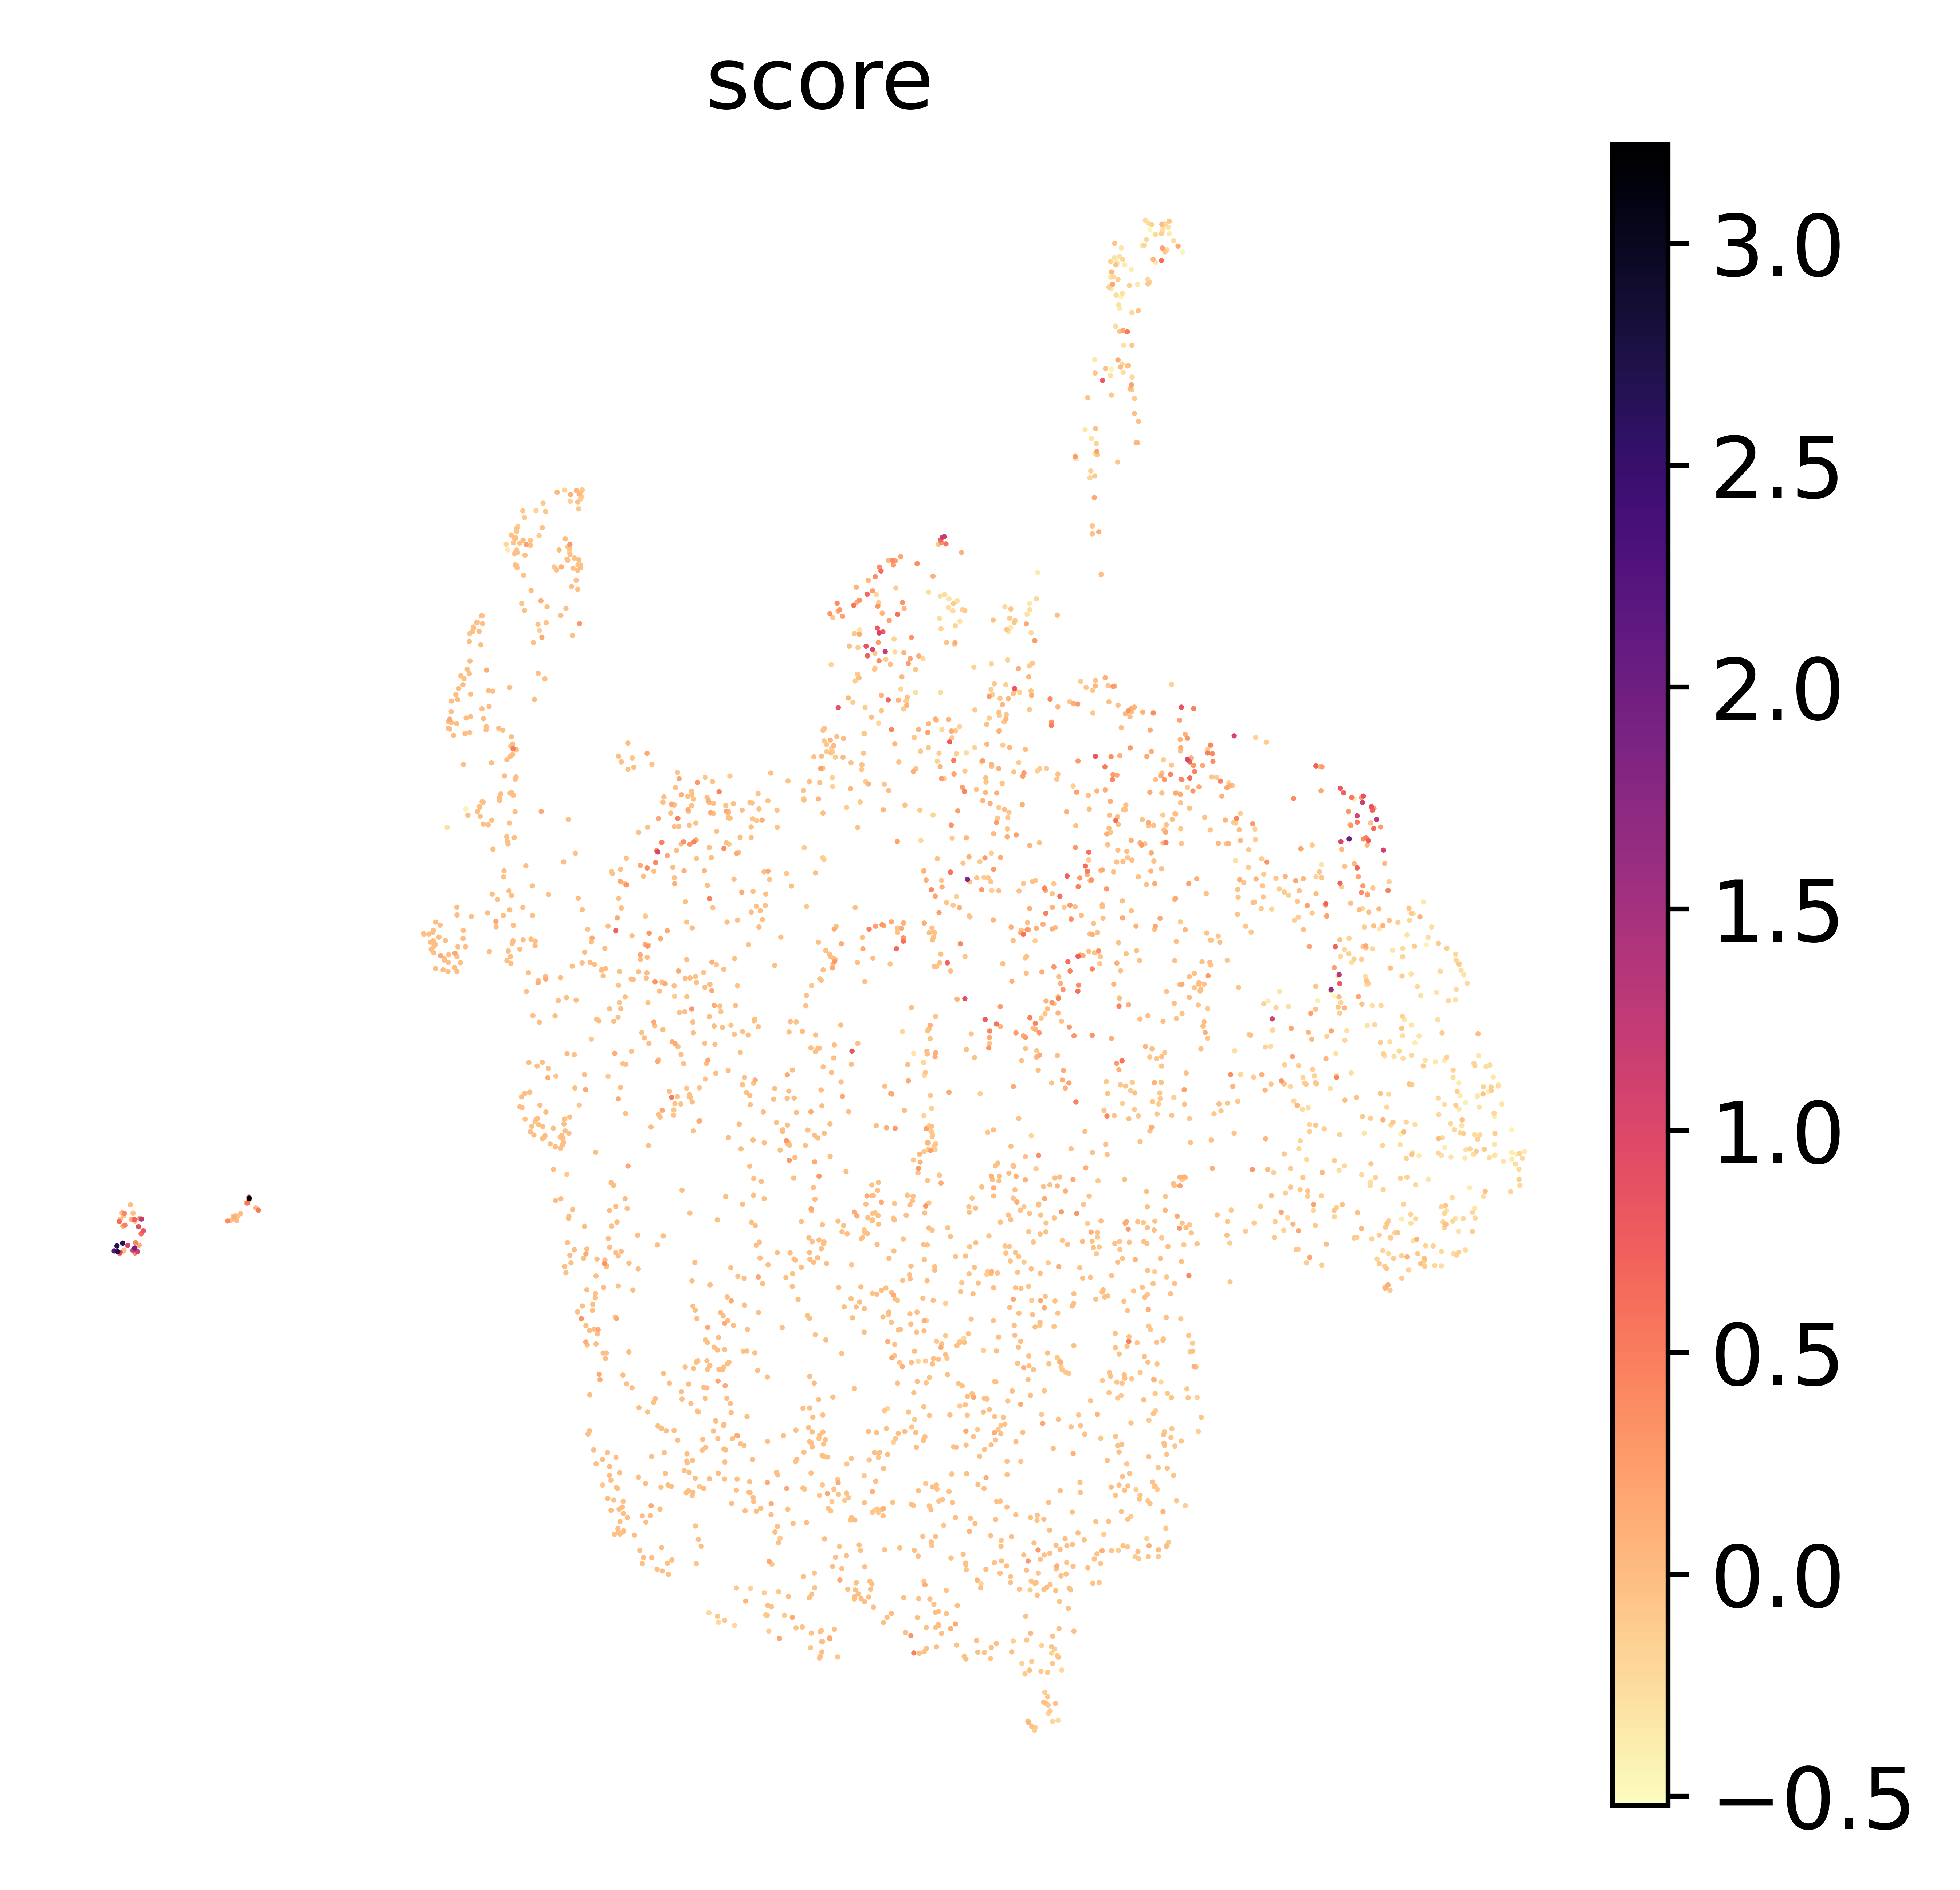

In [15]:
sc.set_figure_params(figsize=(5, 5),dpi=600)
sc.pl.umap(Ishikawa_anndata, color= ['score'], color_map = "magma_r", size = 3, frameon = False)

In [16]:
#Mark stem cells in obs
Ishikawa_anndata.obs['Stem_cells'] = Ishikawa_anndata.obs['score'] > 0.5

In [17]:
#Filter stem cells
Ishikawa_stem_cells_anndata = Ishikawa_anndata[Ishikawa_anndata.obs.Stem_cells == True, :]